![Impressions](https://PixelServer20190423114238.azurewebsites.net/api/impressions/NotebookVM/how-to-use-azureml/automated-machine-learning/forecasting-energy-demand/auto-ml-forecasting-energy-demand.png)

# Automated Machine Learning 2 
## - 시계열 예측
_**에너지 수요 예측**_

## Contents
1. [개념](#개념)
1. [소개](#소개)
1. [셋팅](#셋팅)
1. [데이터작업](#데이터작업)
1. [Train](#Train)

## 개념
자동화 된 시간 계열 실험은 다중 변형 회귀 문제로 처리되며 이전 시계열 데이터는 다른 예측 변수와 함께 회귀로 분석이 됩니다. 

### 시계열 Train 모델
**1. Prophet**  
  : Facebok에서 만든 시계열 예측 모델이며 Python, R에서 사용. 내부 알고리즘은 공개하지 않았기 때문에 대략 Linear Model과 비슷한 정도만 알고 있음.  
  
**2. Auto ARIMA**  
  : AR(자기상관 - 어떤 변수에 의해 이전 값이 이후에 영향을 미치는 상황)과 MA(이동평균 - 평균값이 지속적으로 증가, 감소의 패턴)모형을 합친 것이며 가장 보편적인 시계열 모델  
  
**3. ForecastTCN**   
  : DeepLearning기반 모델


## 소개
이 예에서는 에너지 수요 적용 분야에서 AutoML을 사용하여 단일 시계열을 예측하는 방법을 보여줍니다. 

Process :
1. 기존 작업 공간에서 실험 만들기
2. 간단한 시계열 모델을위한 AutoML 구성 및 로컬 실행
3. 엔지니어링 기능 및 예측 결과보기
4. 지연 및 롤링 윈도우 기능이있는 시계열 모델의 AutoML 구성 및 로컬 실행
5. 기능 중요도 추정

## 셋팅

- 모듈 Import

In [1]:
import azureml.core
import pandas as pd
import numpy as np
import logging
import warnings

# warning 메세지 없이 출력
warnings.showwarning = lambda *args, **kwargs: None

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
from azureml.train.automl import AutoMLConfig
from matplotlib import pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

* workspace 설정

In [2]:
ws = Workspace.from_config()

# 이미 시계열 관련 실험이 있다면 똑같은 실험명으로 할 경우 추가적으로 들어감
experiment_name = 'automl-energydemandforecasting'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Run History Name'] = experiment_name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.69
Subscription ID,cb358e4a-6309-4a82-a6be-ef50c65e1f38
Workspace,mlsrvfordemo
Resource Group,total-rg-demo
Location,koreacentral
Run History Name,automl-energydemandforecasting


## 데이터작업

* Sample Data - 뉴욕시의 에너지 소비 데이터
* Data 내용 - 시간별 에너지 수요 및 기본 날씨 데이터
* csv
* timeStamp 컬럼은 Import 시 parse_dates를 이용하여 parsing

In [6]:
data = pd.read_csv("energy_data/nyc_energy.csv", parse_dates=['timeStamp'])
data.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


### Target Column인 Demand에 NaN값이 있음을 알 수 있음

In [34]:
data.describe()

,demand,precip,temp
count,49124.00,48975.00,49019.00
mean,6067.45,0.00,55.52
std,1285.61,0.02,17.70
min,2859.60,0.00,0.33
25%,5133.86,0.00,41.41
50%,6020.07,0.00,56.26
75%,6684.30,0.00,70.54
max,11456.00,0.91,97.26


In [35]:
data.count()

timeStamp    49205
demand       49124
precip       48975
temp         49019
dtype: int64

In [37]:
data[pd.isnull(data['demand'])].count()

timeStamp    81
demand       0 
precip       81
temp         81
dtype: int64

In [28]:
data[pd.isnull(data['demand'])].head()

,timeStamp,demand,precip,temp
49124,2012-03-11 02:00:00,nan,0.00,37.78
49125,2013-03-10 02:00:00,nan,0.00,38.18
49126,2014-03-09 02:00:00,nan,0.00,40.86
49127,2015-03-08 02:00:00,nan,0.00,36.96
49128,2015-03-11 11:00:00,nan,0.00,49.95


In [4]:
print(type(data['timeStamp']))

<class 'pandas.core.series.Series'>


#### Data Set의 스키마 정의
* y(종속변수) - temp
* x(독립변수) - demand, precip
* 시계열 컬럼 - timeStamp

In [5]:
# 스키마
time_column_name = 'timeStamp'
target_column_name = 'demand'

### Forecast Horizon

  * 데이터 스키마 외에도 예측 범위를 지정  
  * 예측 기간은 일반적으로 Train 데이터의 최신 날짜 이후까지의 시간  
  * Forecas Horizon이란 Time 샘플링 간격. 예를 들어, NYC 에너지 수요 데이터는 시간별 빈도 갖으며 Domain에 따라 다르겠지만 다른 시계열 예측에서는 시간 단위가 몇 주 또는 몇 달 전의 데이터로 Y를 예측하는 시나리오도 있을 수 있음  
  * 이 예에서는 48 시간 동안의 데이터 셋을 지정.

In [14]:
max_horizon = 48

### train, test 셋 Split

* 모델 성능을 평가할 수 있도록 데이터를 Train and Test 세트로 분할 

In [36]:
data[time_column_name].min()

Timestamp('2012-01-01 00:00:00')

In [32]:
# target_column인 demand가 null인 df에서 timeStamp열 추출
print(data[~pd.isnull(data[target_column_name])][time_column_name].head())

# demand가 null인데 가장 최근 날짜 - latest_known_time
latest_known_time = data[~pd.isnull(data[target_column_name])][time_column_name].max()

# max_horizon = 48 시간
# split_time = demand null 최근 날짜 - 48
split_time = latest_known_time - pd.Timedelta(hours=max_horizon)

print("latest_known_time : {}, split_time : {}".format(latest_known_time, split_time))

0   2012-01-01 00:00:00
1   2012-01-01 01:00:00
2   2012-01-01 02:00:00
3   2012-01-01 03:00:00
4   2012-01-01 04:00:00
Name: timeStamp, dtype: datetime64[ns]
latest_known_time : 2017-08-10 05:00:00, split_time : 2017-08-08 05:00:00


In [37]:
# train. test는 split_time 기준으로.
X_train = data[data[time_column_name] <= split_time] # 2012-01-01 ~ 2017-08-08 
X_test = data[(data[time_column_name] > split_time) & (data[time_column_name] <= latest_known_time)] # 2017-08-08 ~ 2017-08-10

In [44]:
X_train.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.50,0.00,46.13
1,2012-01-01 01:00:00,4752.10,0.00,45.89
2,2012-01-01 02:00:00,4542.60,0.00,45.04
3,2012-01-01 03:00:00,4357.70,0.00,45.03
4,2012-01-01 04:00:00,4275.50,0.00,42.61


In [42]:
X_test.head()

,timeStamp,demand,precip,temp
49076,2017-08-08 06:00:00,5590.99,0.00,66.17
49077,2017-08-08 07:00:00,6147.03,0.00,66.29
49078,2017-08-08 08:00:00,6592.43,0.00,66.72
49079,2017-08-08 09:00:00,6874.53,0.00,67.37
49080,2017-08-08 10:00:00,7010.54,0.00,68.30


In [47]:
print("train data set : {} ~ {}".format(X_train.timeStamp.min(), X_train.timeStamp.max()))
print("test data set : {} ~ {}".format(X_test.timeStamp.min(), X_test.timeStamp.max()))

train data set : 2012-01-01 00:00:00 ~ 2017-08-08 05:00:00
test data set : 2017-08-08 06:00:00 ~ 2017-08-10 05:00:00


In [49]:
y_train = X_train.pop(target_column_name).values
y_test = X_test.pop(target_column_name).values

KeyError: 'demand'

## Train

* AutoMLConfig 객체를 인스턴스화 
* 실험을 실행하는 데 사용되는 설정 및 데이터를 정의. 
* 예측 작업의 경우 시계열 데이터 스키마 및 예측 컨텍스트와 관련된 추가 구성을 제공
* 시간 열의 이름과 최대 예측 기간 만 필요

|Property|Description|
|-|-|
|**task**|예측|
|**primary_metric**|최적화를 위해 standard할 메트릭. <br> 시계열 메트릭 <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>
|**iterations**|Iteration 수. 각 이터레이션 할 때마다 Auto ML pipeline은 주어진 데이터로 Train|
|**iteration_timeout_minutes**|iteration 타임 리밋.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**n_cross_validations**|cross validation 분할 수. Rolling Origin Validation은 시계열을 시간적으로 일관된 방식으로 분할하는 데 사용됩니다.|

In [51]:
time_series_settings = {
    'time_column_name': time_column_name,# timeStamp
    'max_horizon': max_horizon # 스키마.
}

automl_config = AutoMLConfig(task='forecasting', #시계열 - forecasting
                             debug_log='automl_nyc_energy_errors.log',
                             primary_metric='normalized_root_mean_squared_error',
                             blacklist_models = ['ExtremeRandomTrees'],
                             iterations=10,
                             iteration_timeout_minutes=5,
                             X=X_train,
                             y=y_train,
                             n_cross_validations=3,
                             verbosity = logging.INFO,
                             **time_series_settings)

* experiment.submit()을 하게 되면 실험이 실행 
* 하드웨어에 따라 프로세스 속도를 높일 수 있습니다.
* 현재 실행중인 Iteration은 확인할 수 있음

In [52]:
local_run = experiment.submit(automl_config, show_output=True)

Running on local machine
Parent Run ID: AutoML_47920a64-b68c-4bdc-8a62-9b5d0b846340
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summ

In [53]:
local_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-energydemandforecasting,AutoML_47920a64-b68c-4bdc-8a62-9b5d0b846340,automl,Running,Link to Azure Portal,Link to Documentation


### Best Model 추출
* 돌린 iteration 중 가장 좋은 결과가 나온 Model 확인
* get_output()을 하게 되면 해당 디렉터리에 fitted model 리턴

In [54]:
best_run, fitted_model = local_run.get_output()
fitted_model.steps

[('timeseriestransformer', TimeSeriesTransformer(logger=None,
             pipeline_type=<TimeSeriesPipelineType.FULL: 1>)),
 ('stackensembleregressor',
  StackEnsembleRegressor(base_learners=[('6', Pipeline(memory=None,
       steps=[('standardscalerwrapper', <automl.client.core.runtime.model_wrappers.StandardScalerWrapper object at 0x7fbfdc3caf60>), ('lightgbmregressor', LightGBMRegressor(boosting_type='gbdt', class_weight=None,
           colsample_bytree=0.5, importance_type='split',
           learning_rate=0.126319473684...=0.825, silent=True, subsample=1,
           subsample_for_bin=200000, subsample_freq=7, verbose=-1))]))],
              meta_learner=ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001,
         fit_intercept=True, l1_ratio=0.5, max_iter=1000, n_alphas=100,
         n_jobs=None, normalize=False, positive=False, precompute='auto',
         random_state=None, selection='cyclic', tol=0.0001, verbose=0),
              training_cv_folds=5))]

### featurized data
* 아래에는 시계열 기능을 사용하여 피철이 된 데이터에 대해 생성 된 내용보기

In [58]:
fitted_model.named_steps['timeseriestransformer'].get_engineered_feature_names()

['precip',
 'temp',
 'precip_WASNULL',
 'temp_WASNULL',
 'year',
 'half',
 'quarter',
 'month',
 'day',
 'hour',
 'am_pm',
 'hour12',
 'wday',
 'qday',
 'week']

### Best Fitted Model 테스트 하기
 
* Forcasting은 `NaN`은 예측자가 실제 값을 채우는 영역임. 
* 예측 기능을 사용하면 가능한 가장 짧은 예측 기간을 사용하여 예측이 생성. 
* NaN 이외의 값이 마지막으로 표시되는 시점은 _forecast origin_ 
* 대상의 값이 마지막으로 알려진 시점입니다.

In [63]:
#demand - y
y_query = y_test.copy().astype(np.float)
y_query

array([5590.992, 6147.033, 6592.425, 6874.533, 7010.542, 7078.158,
       7213.317, 7329.75 , 7426.25 , 7505.633, 7578.192, 7548.05 ,
       7357.117, 7131.433, 6986.575, 6869.292, 6587.058, 6194.442,
       5754.708, 5439.667, 5195.325, 5044.508, 5010.   , 5195.3  ,
       5651.033, 6240.392, 6774.967, 7140.267, 7348.917, 7516.775,
       7671.625, 7806.833, 7949.467, 8065.808, 8162.875, 8136.758,
       7852.642, 7535.067, 7360.883, 7207.583, 6917.65 , 6487.642,
       6053.458, 5714.258, 5497.025, 5360.583, 5333.775, 5534.683])

* 해당 y를 nan으로 fill - 실제로 테스트 할 떄 y는 nan 이기 떄문에

In [64]:
y_query.fill(np.nan)

In [65]:
y_query

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [66]:
y_fcst, X_trans = fitted_model.forecast(X_test, y_query)

In [67]:
y_fcst # 예측

array([5414.30973998, 5842.83330722, 6219.27666272, 6219.27666272,
       6260.19831813, 6260.19831813, 6630.29474928, 6972.06674404,
       6972.06674404, 7144.85439454, 7393.47147445, 7492.38139516,
       7393.47147445, 7252.30685575, 6972.06674404, 6708.04063426,
       6405.84416416, 6335.44153731, 5249.9984181 , 5209.07676269,
       5209.07676269, 5209.07676269, 5209.07676269, 5209.07676269,
       5414.30973998, 5842.83330722, 6219.27666272, 6401.88274915,
       6845.16059024, 7093.77767015, 7576.93653127, 7679.79002411,
       7679.79002411, 7679.79002411, 7679.79002411, 7679.79002411,
       7679.79002411, 7492.38139516, 7252.30685575, 6905.31087974,
       6550.34591344, 6477.12596833, 5521.42863262, 5391.68284912,
       5391.68284912, 5320.40104495, 5249.9984181 , 5249.9984181 ])

In [68]:
y_test # 실제

array([5590.992, 6147.033, 6592.425, 6874.533, 7010.542, 7078.158,
       7213.317, 7329.75 , 7426.25 , 7505.633, 7578.192, 7548.05 ,
       7357.117, 7131.433, 6986.575, 6869.292, 6587.058, 6194.442,
       5754.708, 5439.667, 5195.325, 5044.508, 5010.   , 5195.3  ,
       5651.033, 6240.392, 6774.967, 7140.267, 7348.917, 7516.775,
       7671.625, 7806.833, 7949.467, 8065.808, 8162.875, 8136.758,
       7852.642, 7535.067, 7360.883, 7207.583, 6917.65 , 6487.642,
       6053.458, 5714.258, 5497.025, 5360.583, 5333.775, 5534.683])

In [69]:
# limit the evaluation to data where y_test has actuals
def align_outputs(y_predicted, X_trans, X_test, y_test, predicted_column_name = 'predicted'):
    """
    Typical causes of misalignment are:
    * we predicted some periods that were missing in actuals -> drop from eval
    * model was asked to predict past max_horizon -> increase max horizon
    * data at start of X_test was needed for lags -> provide previous periods
    """
    df_fcst = pd.DataFrame({predicted_column_name : y_predicted})
    # y and X outputs are aligned by forecast() function contract
    df_fcst.index = X_trans.index
    
    # align original X_test to y_test    
    X_test_full = X_test.copy()
    X_test_full[target_column_name] = y_test

    # X_test_full's does not include origin, so reset for merge
    df_fcst.reset_index(inplace=True)
    X_test_full = X_test_full.reset_index().drop(columns='index')
    together = df_fcst.merge(X_test_full, how='right')
    
    # drop rows where prediction or actuals are nan 
    # happens because of missing actuals 
    # or at edges of time due to lags/rolling windows
    clean = together[together[[target_column_name, predicted_column_name]].notnull().all(axis=1)]
    return(clean)

df_all = align_outputs(y_fcst, X_trans, X_test, y_test)
df_all.head()

,timeStamp,_automl_dummy_grain_col,predicted,precip,temp,demand
0,2017-08-08 06:00:00,_automl_dummy_grain_col,5414.31,0.00,66.17,5590.99
1,2017-08-08 07:00:00,_automl_dummy_grain_col,5842.83,0.00,66.29,6147.03
2,2017-08-08 08:00:00,_automl_dummy_grain_col,6219.28,0.00,66.72,6592.43
3,2017-08-08 09:00:00,_automl_dummy_grain_col,6219.28,0.00,67.37,6874.53
4,2017-08-08 10:00:00,_automl_dummy_grain_col,6260.20,0.00,68.30,7010.54


X_trans를 보면 데이터에 어떤 기능이 발생했는지 확인할 수 있음

In [70]:
X_trans

,,precip,temp,precip_WASNULL,temp_WASNULL,year,half,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,0.00,66.17,0,0,2017,2,3,8,8,6,0,6,1,39,32,5414.31
2017-08-08 07:00:00,_automl_dummy_grain_col,0.00,66.29,0,0,2017,2,3,8,8,7,0,7,1,39,32,5842.83
2017-08-08 08:00:00,_automl_dummy_grain_col,0.00,66.72,0,0,2017,2,3,8,8,8,0,8,1,39,32,6219.28
2017-08-08 09:00:00,_automl_dummy_grain_col,0.00,67.37,0,0,2017,2,3,8,8,9,0,9,1,39,32,6219.28
2017-08-08 10:00:00,_automl_dummy_grain_col,0.00,68.30,0,0,2017,2,3,8,8,10,0,10,1,39,32,6260.20
2017-08-08 11:00:00,_automl_dummy_grain_col,0.00,68.89,0,0,2017,2,3,8,8,11,0,11,1,39,32,6260.20
2017-08-08 12:00:00,_automl_dummy_grain_col,0.00,70.60,0,0,2017,2,3,8,8,12,1,12,1,39,32,6630.29
2017-08-08 13:00:00,_automl_dummy_grain_col,0.00,72.83,0,0,2017,2,3,8,8,13,1,1,1,39,32,6972.07
2017-08-08 14:00:00,_automl_dummy_grain_col,0.00,73.33,0,0,2017,2,3,8,8,14,1,2,1,39,32,6972.07


### 정확도 metrics 계산
* 시계열 예측 대한 몇 가지 정확도 메트릭을 계산하고 테스트 세트의 시간 범위에 대한 예측 대 실제 값을 플로팅

In [71]:
def MAPE(actual, pred):
    """
    Calculate mean absolute percentage error.
    Remove NA and values where actual is close to zero
    """
    not_na = ~(np.isnan(actual) | np.isnan(pred))
    not_zero = ~np.isclose(actual, 0.0)
    actual_safe = actual[not_na & not_zero]
    pred_safe = pred[not_na & not_zero]
    APE = 100*np.abs((actual_safe - pred_safe)/actual_safe)
    return np.mean(APE)

Simple forecasting model
[Test Data] 
Root Mean squared error: 358.92
mean_absolute_error score: 289.60
MAPE: 4.27


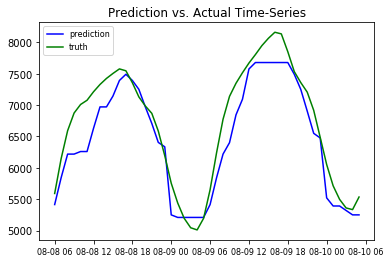

In [72]:
print("Simple forecasting model")
rmse = np.sqrt(mean_squared_error(df_all[target_column_name], df_all['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_all[target_column_name], df_all['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_all[target_column_name], df_all['predicted']))

# Plot outputs
%matplotlib inline
pred, = plt.plot(df_all[time_column_name], df_all['predicted'], color='b')
actual, = plt.plot(df_all[time_column_name], df_all[target_column_name], color='g')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.title('Prediction vs. Actual Time-Series')

plt.show()

The distribution looks a little heavy tailed: we underestimate the excursions of the extremes. A normal-quantile transform of the target might help, but let's first try using some past data with the lags and rolling window transforms.

분포는 약간 굵은 꼬리처럼 보입니다. 극단의 여행을 과소 평가합니다. 대상의 정규 양자 변환이 도움이 될 수 있지만 먼저 지연 및 롤링 창 변환과 함께 일부 과거 데이터를 사용해 봅시다.

### lags 와 rolling window features 사용

We did not use lags in the previous model specification. In effect, the prediction was the result of a simple regression on date, grain and any additional features. This is often a very good prediction as common time series patterns like seasonality and trends can be captured in this manner. Such simple regression is horizon-less: it doesn't matter how far into the future we are predicting, because we are not using past data. In the previous example, the horizon was only used to split the data for cross-validation.

Now that we configured target lags, that is the previous values of the target variables, and the prediction is no longer horizon-less. We therefore must still specify the `max_horizon` that the model will learn to forecast. The `target_lags` keyword specifies how far back we will construct the lags of the target variable, and the `target_rolling_window_size` specifies the size of the rolling window over which we will generate the `max`, `min` and `sum` features.

This notebook uses the blacklist_models parameter to exclude some models that take a longer time to train on this dataset.  You can choose to remove models from the blacklist_models list but you may need to increase the iteration_timeout_minutes parameter value to get results.

이전 모델 사양에서는 지연을 사용하지 않았습니다. 실제로, 예측은 날짜, 그레인 및 추가 기능에 대한 간단한 회귀의 결과였습니다. 계절 성과 추세와 같은 일반적인 시계열 패턴을 이러한 방식으로 캡처 할 수 있기 때문에 이는 종종 매우 좋은 예측입니다. 이러한 단순한 회귀는 지평이 없습니다. 과거 데이터를 사용하지 않기 때문에 예측하는 미래는 중요하지 않습니다. 이전 예에서 수평선은 교차 유효성 검사를 위해 데이터를 분할하는 데만 사용되었습니다.

이제 목표 지연의 목표 값, 즉 목표 변수의 이전 값을 구성했으며 예측에 더 이상 수평선이 없습니다. 따라서 모델이 예측하는 법을 배우는 'max_horizon'을 지정해야합니다. `target_lags` 키워드는 대상 변수의 래그를 구성 할 거리를 지정하고`target_rolling_window_size`는`max`,`min` 및`sum` 기능을 생성 할 롤링 윈도우의 크기를 지정합니다.

이 노트북은 blacklist_models 매개 변수를 사용하여이 데이터 세트를 학습하는 데 시간이 오래 걸리는 일부 모델을 제외합니다. blacklist_models 목록에서 모델을 제거하도록 선택할 수 있지만 결과를 얻으려면 iteration_timeout_minutes 매개 변수 값을 늘려야 할 수도 있습니다.

In [73]:
time_series_settings_with_lags = {
    'time_column_name': time_column_name,
    'max_horizon': max_horizon,
    'target_lags': 12,
    'target_rolling_window_size': 4
}

automl_config_lags = AutoMLConfig(task='forecasting',
                                  debug_log='automl_nyc_energy_errors.log',
                                  primary_metric='normalized_root_mean_squared_error',
                                  blacklist_models=['ElasticNet','ExtremeRandomTrees','GradientBoosting','XGBoostRegressor'],
                                  iterations=10,
                                  iteration_timeout_minutes=10,
                                  X=X_train,
                                  y=y_train,
                                  n_cross_validations=3,
                                  verbosity=logging.INFO,
                                  **time_series_settings_with_lags)

We now start a new local run, this time with lag and rolling window featurization. AutoML applies featurizations in the setup stage, prior to iterating over ML models. The full training set is featurized first, followed by featurization of each of the CV splits. Lag and rolling window features introduce additional complexity, so the run will take longer than in the previous example that lacked these featurizations.

In [74]:
local_run_lags = experiment.submit(automl_config_lags, show_output=True)

Running on local machine
Parent Run ID: AutoML_df5ea323-6137-4df5-bc78-46be7ebd68e9
Current status: DatasetFeaturization. Beginning to featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating CV splits.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: DatasetFeaturization. Beginning to featurize the CV split.
Current status: DatasetFeaturizationCompleted. Completed featurizing the CV split.
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summ

In [75]:
best_run_lags, fitted_model_lags = local_run_lags.get_output()
y_fcst_lags, X_trans_lags = fitted_model_lags.forecast(X_test, y_query)
df_lags = align_outputs(y_fcst_lags, X_trans_lags, X_test, y_test)
df_lags.head()

,timeStamp,_automl_dummy_grain_col,origin,predicted,precip,temp,demand
0,2017-08-08 06:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,4977.51,0.00,66.17,5590.99
1,2017-08-08 07:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6422.75,0.00,66.29,6147.03
2,2017-08-08 08:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6697.30,0.00,66.72,6592.43
3,2017-08-08 09:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6775.36,0.00,67.37,6874.53
4,2017-08-08 10:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6775.36,0.00,68.30,7010.54


In [76]:
X_trans_lags

,,,horizon_origin,precip,precip_WASNULL,temp,temp_WASNULL,_automl_target_col_lag12H,_automl_target_col_min_window4H,_automl_target_col_max_window4H,_automl_target_col_mean_window4H,year,...,quarter,month,day,hour,am_pm,hour12,wday,qday,week,_automl_target_col
timeStamp,_automl_dummy_grain_col,origin,,,,,,,,,,,,,,,,,,,,,
2017-08-08 06:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,1,0.00,0.00,66.17,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,6,0,6,1,39,32,4977.51
2017-08-08 07:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,2,0.00,0.00,66.29,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,7,0,7,1,39,32,6422.75
2017-08-08 08:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,3,0.00,0.00,66.72,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,8,0,8,1,39,32,6697.30
2017-08-08 09:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,4,0.00,0.00,67.37,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,9,0,9,1,39,32,6775.36
2017-08-08 10:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,5,0.00,0.00,68.30,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,10,0,10,1,39,32,6775.36
2017-08-08 11:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,6,0.00,0.00,68.89,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,11,0,11,1,39,32,6775.36
2017-08-08 12:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,7,0.00,0.00,70.60,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,12,1,12,1,39,32,7287.06
2017-08-08 13:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,8,0.00,0.00,72.83,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,13,1,1,1,39,32,7502.92
2017-08-08 14:00:00,_automl_dummy_grain_col,2017-08-08 05:00:00,9,0.00,0.00,73.33,0.00,6831.23,4867.02,5120.31,4955.81,2017,...,3,8,8,14,1,2,1,39,32,7670.05


Forecasting model with lags
[Test Data] 
Root Mean squared error: 347.57
mean_absolute_error score: 283.43
MAPE: 4.37


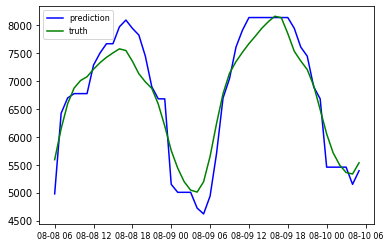

In [77]:
print("Forecasting model with lags")
rmse = np.sqrt(mean_squared_error(df_lags[target_column_name], df_lags['predicted']))
print("[Test Data] \nRoot Mean squared error: %.2f" % rmse)
mae = mean_absolute_error(df_lags[target_column_name], df_lags['predicted'])
print('mean_absolute_error score: %.2f' % mae)
print('MAPE: %.2f' % MAPE(df_lags[target_column_name], df_lags['predicted']))

# Plot outputs
%matplotlib inline
pred, = plt.plot(df_lags[time_column_name], df_lags['predicted'], color='b')
actual, = plt.plot(df_lags[time_column_name], df_lags[target_column_name], color='g')
plt.xticks(fontsize=8)
plt.legend((pred, actual), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()

### What features matter for the forecast?
The following steps will allow you to compute and visualize engineered feature importance based on your test data for forecasting. 

#### Setup the model explanations for AutoML models
The *fitted_model* can generate the following which will be used for getting the engineered and raw feature explanations using *automl_setup_model_explanations*:-
1. Featurized data from train samples/test samples 
2. Gather engineered and raw feature name lists
3. Find the classes in your labeled column in classification scenarios

The *automl_explainer_setup_obj* contains all the structures from above list. 

In [78]:
from azureml.train.automl.automl_explain_utilities import AutoMLExplainerSetupClass, automl_setup_model_explanations
automl_explainer_setup_obj = automl_setup_model_explanations(fitted_model, X=X_train.copy(), 
                                                             X_test=X_test.copy(), y=y_train, 
                                                             task='forecasting')

Current status: Setting up data for AutoMl explanations
Current status: Setting up the AutoML featurization for explanations
Current status: Setting up the AutoML estimator
Current status: Setting up the AutoML featurizer
Current status: Generating a feature map for raw feature importance
Current status: Data for AutoMl explanations successfully setup


#### Initialize the Mimic Explainer for feature importance
For explaining the AutoML models, use the *MimicWrapper* from *azureml.explain.model* package. The *MimicWrapper* can be initialized with fields in *automl_explainer_setup_obj*, your workspace and a LightGBM model which acts as a surrogate model to explain the AutoML model (*fitted_model* here). The *MimicWrapper* also takes the *best_run* object where the raw and engineered explanations will be uploaded.

In [79]:
from azureml.explain.model.mimic.models.lightgbm_model import LGBMExplainableModel
from azureml.explain.model.mimic_wrapper import MimicWrapper
explainer = MimicWrapper(ws, automl_explainer_setup_obj.automl_estimator, LGBMExplainableModel, 
                         init_dataset=automl_explainer_setup_obj.X_transform, run=best_run,
                         features=automl_explainer_setup_obj.engineered_feature_names, 
                         feature_maps=[automl_explainer_setup_obj.feature_map])

#### Use Mimic Explainer for computing and visualizing engineered feature importance
The *explain()* method in *MimicWrapper* can be called with the transformed test samples to get the feature importance for the generated engineered features. You can also use *ExplanationDashboard* to view the dash board visualization of the feature importance values of the generated engineered features by AutoML featurizers.

In [80]:
engineered_explanations = explainer.explain(['local', 'global'], eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(engineered_explanations.get_feature_importance_dict())
from azureml.contrib.interpret.visualize import ExplanationDashboard
ExplanationDashboard(engineered_explanations, automl_explainer_setup_obj.automl_estimator, automl_explainer_setup_obj.X_test_transform)

{'temp': 510.75992116581347, 'hour': 392.572508126248, 'week': 159.35452585206448, 'wday': 115.49449384066735, 'month': 37.14186716881266, 'quarter': 22.157436190509344, 'hour12': 6.005372561021652, 'qday': 1.8842072128202352, 'half': 0.5576417853821064, 'day': 0.031254465160584735, 'am_pm': 0.0, 'year': 0.0, 'temp_WASNULL': 0.0, 'precip_WASNULL': 0.0, 'precip': 0.0}


ModuleNotFoundError: No module named 'azureml.contrib.interpret'

#### Use Mimic Explainer for computing and visualizing raw feature importance
The *explain()* method in *MimicWrapper* can be again called with the transformed test samples and setting *get_raw* to *True* to get the feature importance for the raw features. You can also use *ExplanationDashboard* to view the dash board visualization of the feature importance values of the raw features.

In [ ]:
raw_explanations = explainer.explain(['local', 'global'], get_raw=True, 
                                     raw_feature_names=automl_explainer_setup_obj.raw_feature_names,
                                     eval_dataset=automl_explainer_setup_obj.X_test_transform)
print(raw_explanations.get_feature_importance_dict())
from azureml.contrib.interpret.visualize import ExplanationDashboard
ExplanationDashboard(raw_explanations, automl_explainer_setup_obj.automl_pipeline, automl_explainer_setup_obj.X_test_raw)

Please go to the Azure Portal's best run to see the top features chart.

The informative features make all sorts of intuitive sense. Temperature is a strong driver of heating and cooling demand in NYC. Apart from that, the daily life cycle, expressed by `hour`, and the weekly cycle, expressed by `wday` drives people's energy use habits.